# Airlines Delay Prediction 
Aim of the project to predict the delay of airlines from the given dataset.

# DataSet
I have Downloaded this dataset from kaggle website. Here is the link: https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay

# What are we required to do
We have to predict the delay of airlines from the given dataset.

# Importing the Required Libraries

In [210]:
import os
import numpy as np
import pandas as pd
import random
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [211]:
df=pd.read_csv('Airlines.csv')
display(df)
print(df.columns.tolist())

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0
539379,539380,FL,398,SEA,ATL,5,1439,305,0
539380,539381,FL,609,SFO,MKE,5,1439,255,0
539381,539382,UA,78,HNL,SFO,5,1439,313,1


['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length', 'Delay']


In [212]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [213]:
df1=labelencoder(df.copy())

In [214]:
n=len(df1)
print(n)
N=list(range(n))
random.seed(2022)
random.shuffle(N)

539383


In [215]:
target=['Delay']
dataY = df1[target]
dataX = df1.drop(target+['id'],axis=1)

trainX=dataX.iloc[N[0:(n//5)*4]]
trainY=dataY.iloc[N[0:(n//5)*4]]

testX=dataX.iloc[N[(n//5)*4:]]
testY=dataY.iloc[N[(n//5)*4:]]

In [216]:
df_columns = list(trainX.columns)
print(df_columns)

['Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length']


In [217]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [218]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [219]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [220]:
train_feat_df = to_feature(trainX)
test_feat_df = to_feature(testX)

100%|██████████| 1/1 [00:00<00:00, 80.23it/s]


createcreate_numeric_feature  0.009[s]


100%|██████████| 1/1 [00:00<00:00, 168.74it/s]

createcreate_numeric_feature  0.004[s]


# Model

In [221]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, params: dict=None, verbose: int=50):
    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float64)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(
            early_stopping_rounds=100,
            verbose=verbose)
        print(f'Fitting model with parameters: {params}')
        
        clf.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)]
            
        )

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [222]:
params = {
    'objective': 'rmse',
    'learning_rate': 0.1,
    'reg_lambda': 1.0,
    'reg_alpha': 0.1,
    'max_depth': 5,
    'n_estimators': 10000,
    'colsample_bytree': 0.5,
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': 0.9,
    'importance_type': 'gain',
    'random_state': 71,
    'num_leaves': 62,
    'early_stopping_rounds': 100,
}

In [223]:
y = trainY
ydf=pd.DataFrame(y)
display(ydf)

,Delay
58229,0
426517,0
466581,1
61072,1
289132,1
...,...
184301,0
135084,1
83635,0
295802,0


Fitting model with parameters: {'objective': 'rmse', 'learning_rate': 0.1, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'max_depth': 5, 'n_estimators': 10000, 'colsample_bytree': 0.5, 'min_child_samples': 10, 'subsample_freq': 3, 'subsample': 0.9, 'importance_type': 'gain', 'random_state': 71, 'num_leaves': 62, 'early_stopping_rounds': 100}
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.005691
[LightGBM] [Debug] init for col-wise cost 0.000004 seconds, init for row-wise cost 0.004086 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the

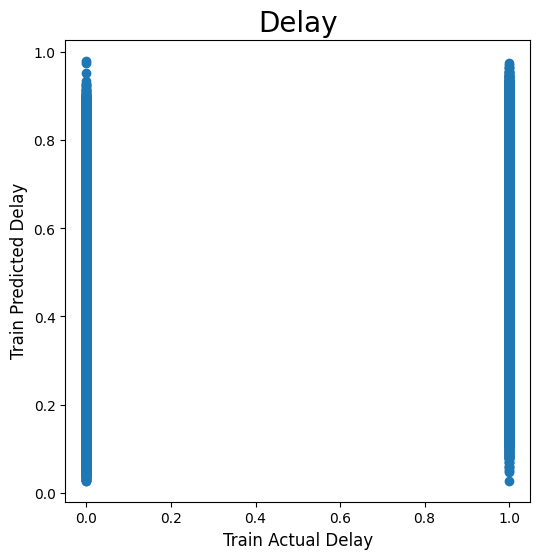

In [224]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi = ydf.iloc[:, i]
    y = np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(target[i], fontsize=20)
    ax.set_ylabel('Train Predicted ' + target[i], fontsize=12)
    ax.set_xlabel('Train Actual ' + target[i], fontsize=12)
    ax.scatter(y, oof)

# Visualize Importance

In [225]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

Fitting model with parameters: {'objective': 'rmse', 'learning_rate': 0.1, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'max_depth': 5, 'n_estimators': 10000, 'colsample_bytree': 0.5, 'min_child_samples': 10, 'subsample_freq': 3, 'subsample': 0.9, 'importance_type': 'gain', 'random_state': 71, 'num_leaves': 62, 'early_stopping_rounds': 100}
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.005691
[LightGBM] [Debug] init for col-wise cost 0.000004 seconds, init for row-wise cost 0.003647 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the

C:\Users\priya\AppData\Local\Temp\ipykernel_30320\3011810601.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




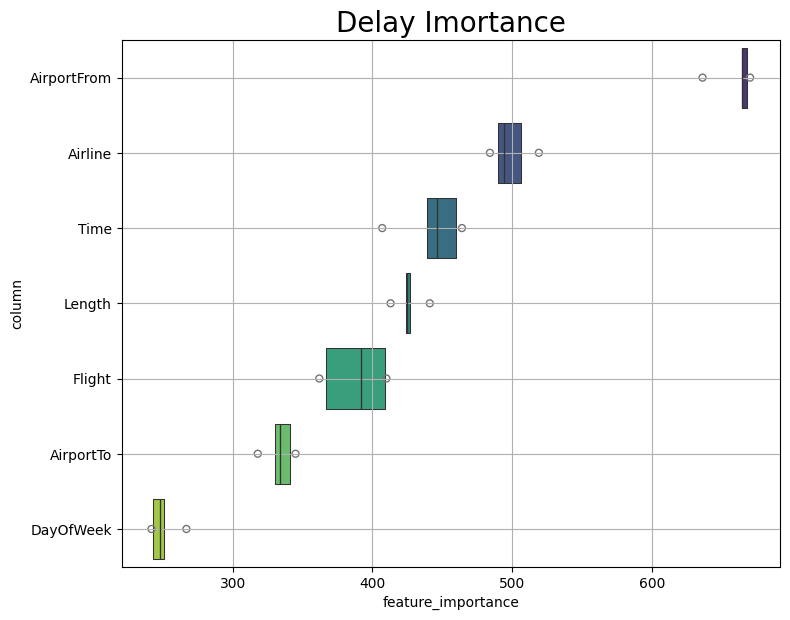

In [226]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

In [227]:
preds=[]
for i in range(5):
    preds += [models[i].predict(test_feat_df.values)/5]
predsT=np.array(preds).T
print(predsT.shape)
preds2=[]
for item in predsT:
    preds2+=[sum(item)]
print(np.array(preds2).shape)

(107879, 5)
(107879,)


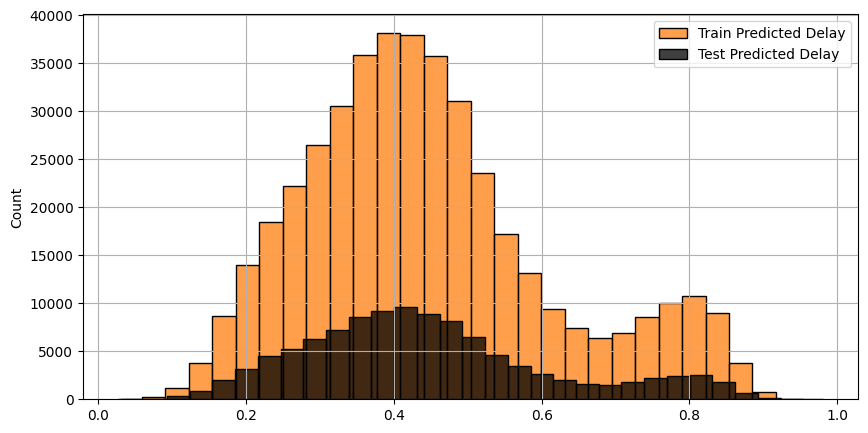

In [228]:
for i in range(1):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(oof, label='Train Predicted '+target[i], ax=ax, color='C1',bins=30)
    sns.histplot(preds2, label='Test Predicted '+target[i], ax=ax, color='black',bins=30)
    ax.legend()
    ax.grid()

In [229]:
Pred=[]
for item in preds2:
    Pred+=[round(item,0)]
from sklearn.metrics import classification_report
print(classification_report(testY,Pred))

              precision    recall  f1-score   support

           0       0.65      0.83      0.73     59794
           1       0.68      0.45      0.54     48085

    accuracy                           0.66    107879
   macro avg       0.66      0.64      0.64    107879
weighted avg       0.66      0.66      0.65    107879



In [230]:
df['Delay'] = pd.to_numeric(df['Delay'], errors='coerce')
df2 = df.groupby('Airline', as_index=False)['Delay'].mean().sort_values('Delay', ascending=False)[['Airline', 'Delay']]


In [231]:
fig = px.bar(df2, x='Airline', y='Delay',title="Airline Delay Ratio")
fig.show()

# Conclusion
- Model is created.
- Visualize Importance is done.
- prediction is done.
- Airline Delay Ratio is shown.
- WN will delay the most.
